In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
#from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split#, HalvingGridSearchCV
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras.optimizers.legacy import RMSprop
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
def scale_data_and_get_dummies(data, location_bucket):
    # scale data except location bucket and demand
    col_scale_list = data.columns.to_list()
    col_scale_list.remove(location_bucket)
    col_scale_list.remove("demand")
    scaler = StandardScaler()
    data[col_scale_list] = scaler.fit_transform(data[col_scale_list])
    # create one hot encoding for location bucket feature
    data = pd.get_dummies(data, columns=[location_bucket], dtype=int)
    return data

def split_train_test(data, target_col="demand"):
    # split data into train and test
    X = data.drop(columns=[target_col])
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4711)
    return X_train, X_test, y_train, y_test 

In [3]:
time_bucket_length = 6
location_bucket = "h3_07"

In [4]:
print(f"Time bucket length: {time_bucket_length}h")
print(f"Location bucket: {location_bucket}")

# read in data
data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
print(data.shape)

Time bucket length: 6h
Location bucket: h3_07
(39374, 13)


In [5]:
# create sample from data with 10 hexagons
sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 30)
data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
print(data_sampled.shape)
if data_sampled.shape[0] >= 50000:
    data_sampled = data_sampled.sample(50000, random_state=4711)
    print(data_sampled.shape)

data_sampled = data

(16428, 13)


In [6]:
# scale data and create one hot encoding for location bucket feature
scaled_data = scale_data_and_get_dummies(data_sampled, location_bucket)
print(scaled_data.shape)

(39374, 103)


In [7]:
# split data into train and test
X_train, X_test, y_train, y_test = split_train_test(scaled_data)

In [8]:
def build_model(X_train, layer_nodes = [64, 64], learning_rate=0.001, dropout=0, activation = 'relu', optimizer = RMSprop):
    model = models.Sequential()
    model.add(layers.Dense(layer_nodes[0], activation=activation, input_shape=(X_train.shape[1],)))
    for nodes in layer_nodes[1:]:
        model.add(layers.Dense(nodes, activation=activation))
        if dropout >= 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='relu'))

    opt = optimizer(lr=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

In [9]:
hyperaparameters = {
    'layer_nodes': [64, 64],
    'learning_rate': 0.001,
    'dropout': 0,
    'activation': 'relu',
    'optimizer': RMSprop
}

def k_fold_nn(
        X_train, 
        y_train, 
        k=4, 
        epochs=50, 
        batch_size=1, 
        verbose=0,
        hyperaparams=hyperaparameters
        ):
    num_val_samples = len(X_train) // k
    num_epochs = epochs
    all_scores_mae = []
    all_scores_mse = []
    all_mae_histories = []
    all_mse_histories = []

    for i in range(k):
        print('processing fold #', i, " of ", k)
        val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]    # Slice Get Validation Data 
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples] # Slice Val. Target Data

        # Exclude validation data from the training data
        partial_train_data = np.concatenate(
            [
                X_train[:i * num_val_samples],
                X_train[(i + 1) * num_val_samples:]
            ],
            axis=0)
        partial_train_targets = np.concatenate(
            [
                y_train[:i * num_val_samples],
                y_train[(i + 1) * num_val_samples:]
            ],
            axis=0)
        
        # build, fit and evaluate Model
        model = build_model(
            X_train,
            layer_nodes=hyperaparams["layer_nodes"],
            learning_rate=hyperaparams["learning_rate"],
            dropout=hyperaparams["dropout"],
            activation=hyperaparams["activation"],
            optimizer=hyperaparams["optimizer"])
        
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=20, 
            min_delta=y_train.std()*0.1, 
            restore_best_weights=True)

        history = model.fit(
            partial_train_data,
            partial_train_targets,
            validation_data=(val_data, val_targets),
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=verbose,
            callbacks=[early_stop]
            )
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=verbose)

        # add metrics to lists
        all_mae_histories.append(history.history['mae'])
        all_mse_histories.append(history.history['loss'])
        all_scores_mae.append(val_mae)
        all_scores_mse.append(val_mse)

    # return metrics
    return all_scores_mae, all_scores_mse, all_mae_histories, all_mse_histories

In [10]:
val_mae, val_mse, mae_hist, mse_hist = k_fold_nn(
    X_train, 
    y_train, 
    k=5, 
    epochs=1000, 
    batch_size=64)

processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


In [17]:
# Get MAE for each k-fold set
np.mean(val_mae)

94.774169921875

In [20]:
y_train.std()

1018.158502667193

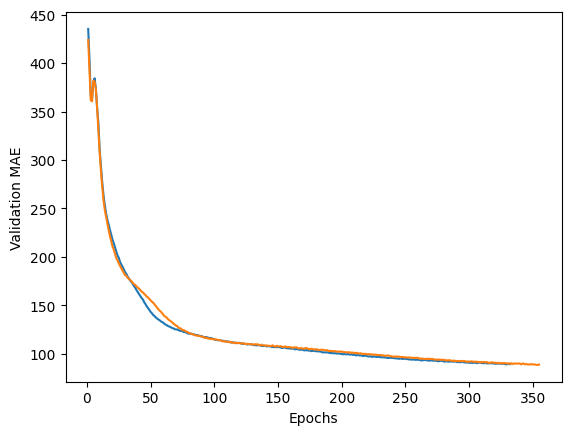

In [18]:
k = 2
# Plot MAE History

for i in range(k):
    plt.plot(range(1, len(mae_hist[i]) + 1), mae_hist[i])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [43]:
# Each iteration generated a history object w
average_mae_history = [np.mean([x[i] for x in mae_hist]) for i in range(50)]

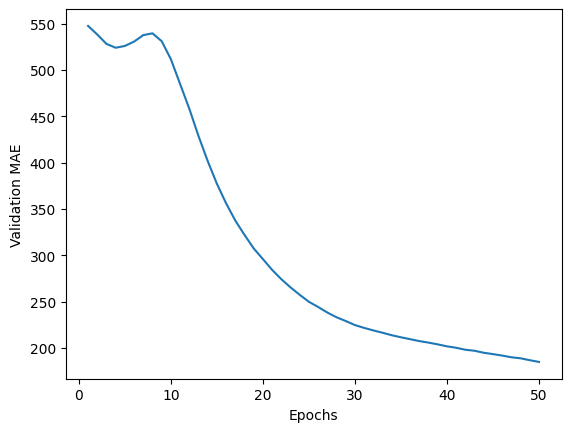

In [44]:
# Plot average MAE History
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [33]:
hyperaparams = hyperaparameters
# Evaluating the Model with the Test Set
model = build_model(X_train,
                    layer_nodes=hyperaparams["layer_nodes"],
                    learning_rate=hyperaparams["learning_rate"],
                    dropout=hyperaparams["dropout"],
                    activation=hyperaparams["activation"],
                    optimizer=hyperaparams["optimizer"])
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=0)
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 495us/step - loss: 99316.4297 - mae: 116.8060


In [34]:
# Voila.
test_mae_score

116.80601501464844

In [42]:


k = 4
num_val_samples = len(X_train) // k # returns an integer instead of float
num_epochs = 4
all_scores_mae = []
all_scores_mse = []
all_mae_histories = []
all_mse_histories = []

for i in range(k):
    print('processing fold #', i) 
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]    # Slice Get Validation Data 
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples] # Slice Val. Target Data
    
    # Exclude validation data from the training data
    partial_train_data = np.concatenate(
        [
            X_train[:i * num_val_samples],
            X_train[(i + 1) * num_val_samples:]
        ],
        axis=0)
    partial_train_targets = np.concatenate(
        [
            y_train[:i * num_val_samples],
            y_train[(i + 1) * num_val_samples:]
        ],
        axis=0)
    
    # Build Model
    model = build_model(X_train)

    # Fit Model
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)

    # Cache MAE History  # <-- This is changed
    mae_history = history.history['mae']  
    mse_history = history.history['loss']  
    
    # Evaluate Model
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    # Add Mean Absolut Error to All Scored List
    all_scores_mae.append(val_mae)
    all_scores_mse.append(val_mse)

    # Add Mean Absolut Error to All Scored List # <-- This is changed
    all_mae_histories.append(mae_history)
    all_mse_histories.append(mse_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
## REGULARIZATION
from keras import regularizers
model = models.Sequential()
# kernel_regularizer = regularizers.l2(0.001), add those weights to the loss with an alpha of 0.001
# you could use also: regularizers.l1(0.001) for L1 regularization
# Documentation: https://keras.io/api/layers/regularizers/
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### To recap, these are the most common ways to prevent overfitting in neural networks:
1. Get more training data.
2. Reduce the capacity of the network.
3. Add weight regularization.
4. Add dropout.
5. Data Augmentation (for image classification tasks)